# ***This project is based on the Kaggle competition "New York City Taxi Fare Prediction" by Google Cloud***   
 
#### The dataset can be found here: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data

# Before we look into the data, what do we know about taxi fares in NYC?  

We can get the fare rules from here http://home.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml  

There was a change in the fare rules on the 30/09/2012

## Before 05/09/2012 (in USD)

__Normal Trip:__  
Initial charge: 2  
Surcharge Improvement:  0.30   
Surcharge from 8pm to 6am every day: 0.50  
Surcharge from 4pm to 8pm on weekdays (exc. holidays): 1.00    
Surcharge for dropoff location (NYC, Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange, Putnam): 0.50  

No surcharge for extra pasengers or bags.  
Receipt includes payments for bridges and tunnels.  

Meter: 0.40 per 1/5 mile or 0.40 per 60 seconds when vehicle is stopped.

__Airport Trip:__  
To-From La Guardia: Normal Trip  
To-From JFK and any location in NYC excluding Manhattan: Normal Trip
To/From JFK and any location in Manhattan: 45 + 4.5 if from 4pm to 8pm on weekdays (exc. holidays) + tolls  
To Newark: Normal trip + 15  


## After 05/09/2012 (in USD)

__Normal Trip:__  
Initial charge: 2.50  
Surcharge Improvement:  0.30   
Surcharge from 8pm to 6am every day: 0.50  
Surcharge from 4pm to 8pm on weekdays (exc. holidays): 1.00    
Surcharge for dropoff location (NYC, Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange, Putnam): 0.50  

No surcharge for extra pasengers or bags.  
Receipt includes payments for bridges and tunnels.  

Meter: 0.50 per 1/5 mile or 0.50 per 60 seconds when vehicle is stopped.

__Airport Trip:__  
To-From La Guardia: Normal Trip  
To-From JFK and any location in NYC excluding Manhattan: Normal Trip
To/From JFK and any location in Manhattan: 52.8 + 4.5 if from 4pm to 8pm on weekdays (exc. holidays) + tolls  
To Newark: Normal trip + 17.5  

It seems reasonable that we have to categorize the trips on the dataset based on the above rules, and that we should extract features and conditions from the geolocation and datetime of the trips. The hardest part will be to factor in the traffic.



In [436]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
import math
from math import radians

#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import seaborn as sns
sns.set_style("darkgrid")
import folium
import folium.plugins
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Read the Data  

The first thing to do is to read the training set that contains __55 million rows__ of data! The data contains the datetime of the taxi ride, the pickup location, dropoff location, number of passengers and the fare amount. The are some transformations we want to do with the datetime column that we will do them at the same time that we read the data. 

Basically we are going to extract the day of the week, the hour of the day and check if the ride was before or after the fare reform explained before. So first let's define a function that can read csv data and apply those transformations.  

In [437]:
def readData(path, types, chunksize, chunks):

    df_list = []
    counter = 1
    
    for df_chunk in tqdm(pd.read_csv(path, usecols=list(types.keys()), dtype=types, chunksize=chunksize)):

        # The counter helps us stop whenever we want instead of reading the entire data
        if counter == chunks+1:
            break
        counter = counter+1

        # Neat trick from https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
        # Using parse_dates would be much slower!
        df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
        df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'])

        # Process the datetime and get hour of day and day of week
        # After Price Reform - Before Price Reform ('newRate')
        df_chunk['hour'] = df_chunk['pickup_datetime'].apply(lambda x: x.hour)
        df_chunk['weekday'] = df_chunk['pickup_datetime'].apply(lambda x: x.weekday())
        df_chunk['newRate'] = df_chunk['pickup_datetime'].apply(lambda x: True if x > pd.Timestamp(2012, 9, 30, 10) else False)
        df_chunk.drop(columns=['pickup_datetime'], inplace=True)   
        
        # Aappend the chunk to list
        df_list.append(df_chunk) 

    # Merge all dataframes into one dataframe
    df = pd.concat(df_list)

    # Delete the dataframe list to release memory
    del df_list
    
    return df

Now we read the training data. We can define how many rows to read using 'chunksize' and 'chunksnumber'

In [438]:
 # The path where the Training set is
TRAIN_PATH = '../input/train.csv'

# The datatypes we want to pass the reading function
traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'float32'}

# The size of the chunk for each iteration
chunksizeTrain = 1_000_000

# The number of chunks we want to read
chunksnumberTrain = 7

df_train = readData(TRAIN_PATH, traintypes, chunksizeTrain, chunksnumberTrain)





0it [00:00, ?it/s]



1it [00:18, 18.57s/it]



2it [00:37, 18.57s/it]



3it [00:55, 18.41s/it]



4it [01:13, 18.50s/it]



5it [01:31, 18.28s/it]



6it [01:50, 18.38s/it]



7it [02:08, 18.43s/it]

We also read the test data using the same function

In [439]:
 # The path where the Test set is
TEST_PATH = '../input/test.csv'

# The datatypes we want to pass the reading function
testtypes = {'key': 'str',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'float32'}

# The size of the chunk for each iteration
chunksizeTest = 1_000_000

# The number of chunks we want to read
chunksnumberTest = 1

df_test = readData(TEST_PATH, testtypes, chunksizeTest, chunksnumberTest)






0it [00:00, ?it/s]




1it [00:00,  6.84it/s]






Let's have a look at the imported data (train and test datasets)

In [440]:
df_train.head()

fare_amount  pickup_longitude   ...     weekday  newRate
0          4.5        -73.844315   ...           0    False
1         16.9        -74.016045   ...           1    False
2          5.7        -73.982735   ...           3    False
3          7.7        -73.987129   ...           5    False
4          5.3        -73.968094   ...           1    False

[5 rows x 9 columns]

In [441]:
df_train.describe(include='all')

fare_amount  pickup_longitude   ...          weekday  newRate
count   7.000000e+06      7.000000e+06   ...     7.000000e+06  7000000
unique           NaN               NaN   ...              NaN        2
top              NaN               NaN   ...              NaN    False
freq             NaN               NaN   ...              NaN  4103629
mean    1.139670e+01     -6.884929e+01   ...     3.041643e+00      NaN
std     9.743844e+00      1.294817e+01   ...     1.949239e+00      NaN
min    -1.077500e+02     -3.439245e+03   ...     0.000000e+00      NaN
25%     6.000000e+00     -7.399207e+01   ...     1.000000e+00      NaN
50%     8.500000e+00     -7.398182e+01   ...     3.000000e+00      NaN
75%     1.250000e+01     -7.396711e+01   ...     5.000000e+00      NaN
max     1.273310e+03      3.439426e+03   ...     6.000000e+00      NaN

[11 rows x 9 columns]

In [442]:
df_test.head()

key  pickup_longitude   ...     weekday  newRate
0  2015-01-27 13:08:24.0000002        -73.973320   ...           1     True
1  2015-01-27 13:08:24.0000003        -73.986862   ...           1     True
2  2011-10-08 11:53:44.0000002        -73.982521   ...           5    False
3  2012-12-01 21:12:12.0000002        -73.981163   ...           5     True
4  2012-12-01 21:12:12.0000003        -73.966049   ...           5     True

[5 rows x 9 columns]

In [443]:
df_test.describe(include='all')

key   ...     newRate
count                            9914   ...        9914
unique                           9914   ...           2
top     2012-11-20 21:54:00.000000180   ...       False
freq                                1   ...        5634
mean                              NaN   ...         NaN
std                               NaN   ...         NaN
min                               NaN   ...         NaN
25%                               NaN   ...         NaN
50%                               NaN   ...         NaN
75%                               NaN   ...         NaN
max                               NaN   ...         NaN

[11 rows x 9 columns]

## Clean the Data   

The next step is to clean the data. We will:  

1) Drop the rows with null values  
2) Drop rows with fare_amount less than 2.5 USD  
3) Drop rows with fare_amount above 400 USD  
4) Drop rows with passenger_count outside the range 1 to 10    
5) Drop rows with geolocations not close to NYC    

In [444]:
# Function that cleans data
def cleanData(df, isTrain):

    # 1) Drop NaN
    df.dropna(how = 'any', axis = 'rows', inplace = True)
    
    # 2) 3) Drop fares below 2.5 USD or above 400 USD in case the dataset is the Training set
    if isTrain:
        df = df[df['fare_amount']>=2.5]
        df = df[df['fare_amount']<400]
    
    # 4) Drop passenger count below 1 or above 10
    df = df[(df['passenger_count']>=1) & (df['passenger_count']<10)] # Drop lines out of bound passenger count   
    
    # 5) Drop rides outside NYC
    minLon = -74.3
    maxLon = -73.7
    minLat = 40.5
    maxLat = 41

    df = df[df['pickup_latitude'] < maxLat]
    df = df[df['pickup_latitude'] > minLat]
    df = df[df['pickup_longitude'] < maxLon]
    df = df[df['pickup_longitude'] > minLon]

    df = df[df['dropoff_latitude'] < maxLat]
    df = df[df['dropoff_latitude'] > minLat]
    df = df[df['dropoff_longitude'] < maxLon]
    df = df[df['dropoff_longitude'] > minLon]

    # Reset Index
    df.reset_index(inplace=True, drop=True)
    
    return df

# Apply cleaning function to both datasets
df_train = cleanData(df_train, True)

Take a quick look at the dataset after cleaning

In [445]:
df_train.describe(include='all')

fare_amount  pickup_longitude   ...          weekday  newRate
count   6.820505e+06      6.820505e+06   ...     6.820505e+06  6820505
unique           NaN               NaN   ...              NaN        2
top              NaN               NaN   ...              NaN    False
freq             NaN               NaN   ...              NaN  3985987
mean    1.134090e+01     -7.027271e+01   ...     3.041649e+00      NaN
std     9.420609e+00      3.691510e+00   ...     1.949477e+00      NaN
min     2.500000e+00     -7.429988e+01   ...     0.000000e+00      NaN
25%     6.000000e+00     -7.399229e+01   ...     1.000000e+00      NaN
50%     8.500000e+00     -7.398212e+01   ...     3.000000e+00      NaN
75%     1.250000e+01     -7.396838e+01   ...     5.000000e+00      NaN
max     3.250000e+02     -7.370016e+01   ...     6.000000e+00      NaN

[11 rows x 9 columns]

Let's have a quick look at how many data we loss while cleaning

In [446]:
trace = go.Pie(values = [df_train.shape[0],chunksizeTrain*chunksnumberTrain - df_train.shape[0]],
               labels = ["Useful data" , "Data loss due to missing values or other reasons"],
               marker = dict(colors = ['skyblue' ,'yellow'], line = dict(color = "black", width =  1.5)),
               rotation  = 60,
               hoverinfo = 'label+percent',
              )

layout = go.Layout(dict(title = 'Data Cleaning (percentage of data loss)',
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        showlegend=False
                       )
                  )

fig = go.Figure(data=[trace],layout=layout)
py.iplot(fig)
fig = go.Figure(data=[trace],layout=layout)

# Data Exploration  

We will begin now the data exploration. Since we are dealing with geolocation data a good place to start is to see our datapoints on a map to get an initial feeling of what we have. Let's have a look at the pickup locations.

Loading BokehJS ...

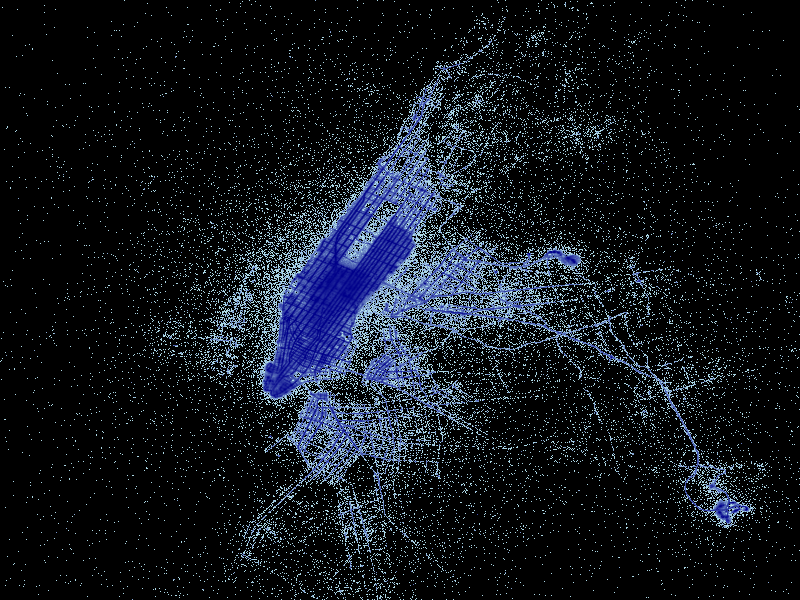

In [447]:
# Using datashader
#Import Libraries
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Hot, inferno, Elevation
from datashader import transfer_functions as tf
output_notebook()

# Define plotting function using Datashader
def plot_data_points(longitude,latitude,data_frame) :
    export  = partial(export_image, export_path="export", background="black")
    fig = figure(background_fill_color = "black")    
    cvs = ds.Canvas(plot_width=800, 
                    plot_height=600,
                    x_range=(-74.15,-73.75), 
                    y_range=(40.6,40.9))
    agg = cvs.points(data_frame,longitude,latitude)
    #img = tf.shade(agg, cmap=Hot, how='eq_hist')
    img = tf.shade(agg)   
    image_xpt = tf.dynspread(img, threshold=0.5, max_px=4)
    return export(image_xpt,'map')

# Call function and plot
plot_data_points('pickup_longitude', 'pickup_latitude', df_train)

In [448]:
# Let's look at some clusters with Folium (20000 points)
samples = df_train.sample(n=min(20000,df_train.shape[0]))
m = folium.Map(location=[np.mean(samples['pickup_latitude']), np.mean(samples['pickup_longitude'])], zoom_start=11)
FastMarkerCluster(data=list(zip(samples['pickup_latitude'], samples['pickup_longitude']))).add_to(m)
folium.LayerControl().add_to(m)
m

# The target variable: the fare

Here we will explore the fares of our training set. We will split the fares in 3 sections based on our intuition and our knowledge related to rides to airports and else:  

1) Up to 40 USD (most of the rides)  
2) From 40 USD to 70 USD (rides including airports)  
3) Above 70 USD (expensive rides)  



/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



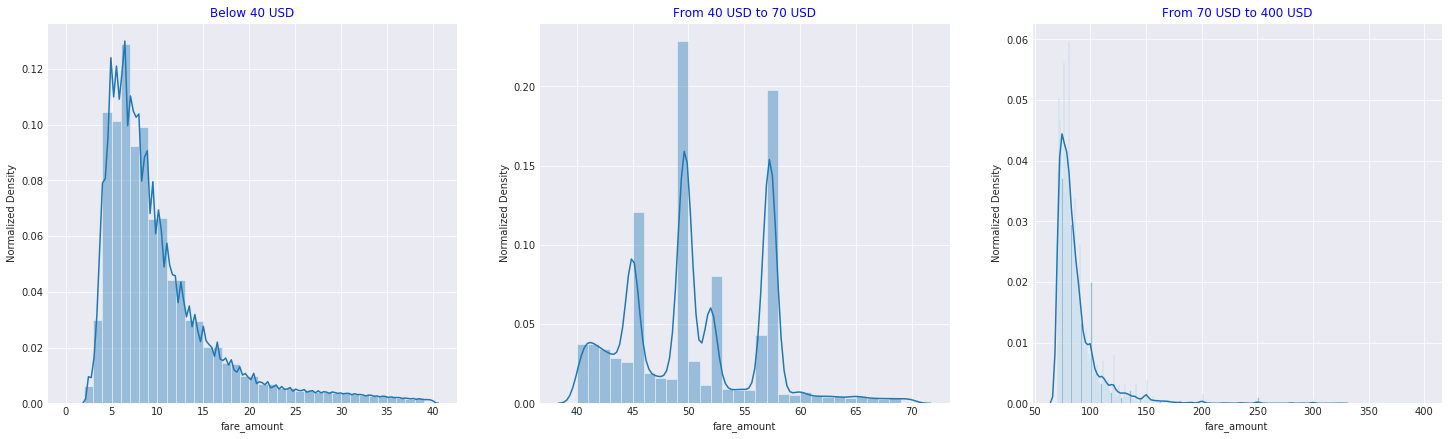

In [449]:
# Define how we want to split the data into sections based on 'fare_amount'
a = 40
b = 70
c = 400

# Plot normalized histogram for each section
plt.figure(figsize = (25,7))
plt.subplot(1,3,1)
plt.title('Below ' + str(a) + ' USD',color = "b")
plt.ylabel('Normalized Density')
sns.distplot(df_train[df_train['fare_amount']<=a]['fare_amount'], norm_hist=True, bins=np.arange(0,a))
plt.subplot(1,3,2)
plt.title('From ' + str(a) + ' USD to ' + str(b) + ' USD',color = "b")
plt.ylabel('Normalized Density')
sns.distplot(df_train[(df_train['fare_amount']>a)&(df_train['fare_amount']<=b)]['fare_amount'], norm_hist=True, bins=np.arange(a,b))
plt.subplot(1,3,3)
plt.title('From ' + str(b) + ' USD to ' + str(c) + ' USD',color = "b")
plt.ylabel('Normalized Density')
sns.distplot(df_train[(df_train['fare_amount']>b)&(df_train['fare_amount']<=c)]['fare_amount'], norm_hist=True, bins=np.arange(b,c));

We know that the fare rules changed at some point in 2012, let's plot the data based on this to see if we can appreciate a different behaviour

Number of data points from before fare rule change: 3985987
Number of data points from after fare rule change: 2834518


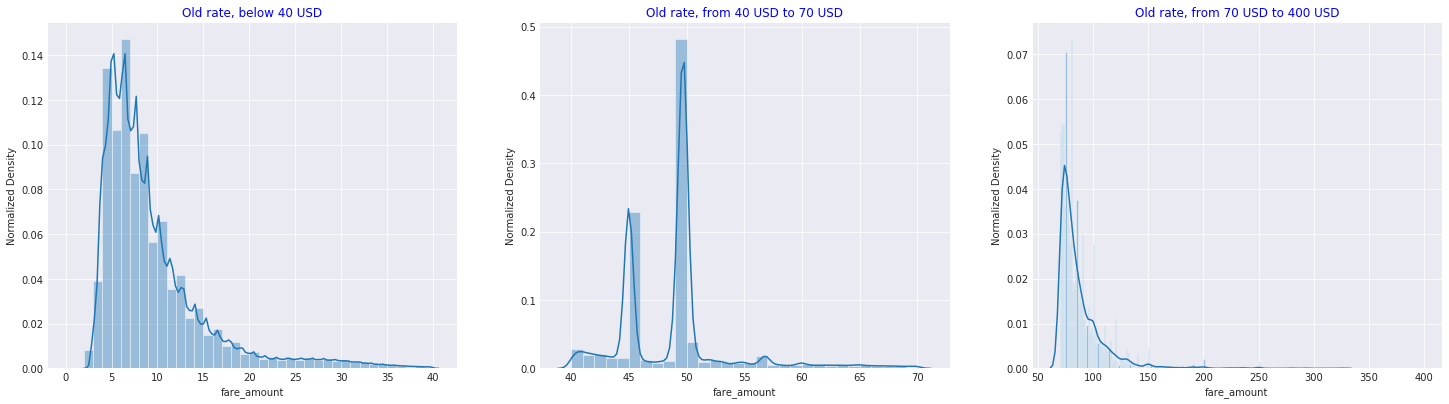

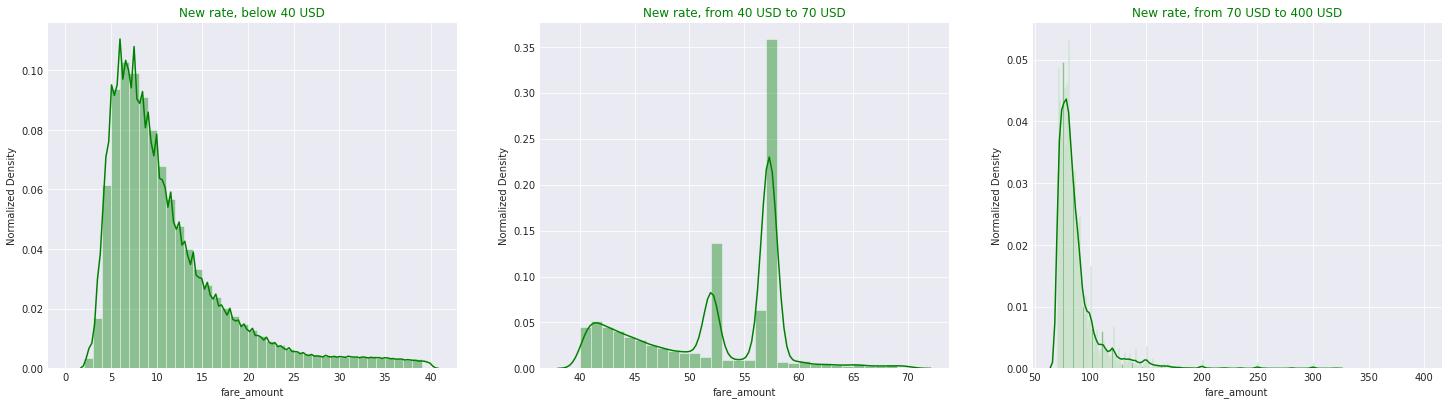

In [450]:
# Split df_train into a dataset of the rides before the fare rules change and after the fare rules change
df_before = df_train[df_train['newRate']==False]
df_after = df_train[df_train['newRate']==True]
print ('Number of data points from before fare rule change: ' + str(df_before.shape[0]))
print ('Number of data points from after fare rule change: ' + str(df_after.shape[0]))

# Plot the sections for the rides before fare rules change
plt.figure(figsize = (25,14))
plt.subplot(2,3,1)
plt.title('Old rate, below ' + str(a) + ' USD',color = "b")
plt.ylabel('Normalized Density')
sns.distplot(df_before[df_before['fare_amount']<=a]['fare_amount'], norm_hist=True, bins=np.arange(0,a))
plt.subplot(2,3,2)
plt.title('Old rate, from ' + str(a) + ' USD to ' + str(b) + ' USD',color = "b")
plt.ylabel('Normalized Density')
sns.distplot(df_before[(df_before['fare_amount']>a)&(df_before['fare_amount']<=b)]['fare_amount'], norm_hist=True, bins=np.arange(a,b))
plt.subplot(2,3,3)
plt.title('Old rate, from ' + str(b) + ' USD to ' + str(c) + ' USD',color = "b")
plt.ylabel('Normalized Density')
sns.distplot(df_before[(df_before['fare_amount']>b)&(df_before['fare_amount']<=c)]['fare_amount'], norm_hist=True, bins=np.arange(b,c)) 

# Plot the sections for the rides after fare rules change
plt.figure(figsize = (25,14))
plt.subplot(2,3,4)
plt.title('New rate, below ' + str(a) + ' USD',color = "g")
plt.ylabel('Normalized Density')
sns.distplot(df_after[df_after['fare_amount']<=a]['fare_amount'], norm_hist=True, color='green', bins=np.arange(0,a))
plt.subplot(2,3,5)
plt.title('New rate, from ' + str(a) + ' USD to ' + str(b) + ' USD',color = "g")
plt.ylabel('Normalized Density')
sns.distplot(df_after[(df_after['fare_amount']>a)&(df_after['fare_amount']<=b)]['fare_amount'], norm_hist=True, color='green', bins=np.arange(a,b))
plt.subplot(2,3,6)
plt.title('New rate, from ' + str(b) + ' USD to ' + str(c) + ' USD',color = "g")
plt.ylabel('Normalized Density')
sns.distplot(df_after[(df_after['fare_amount']>b)&(df_after['fare_amount']<=c)]['fare_amount'], norm_hist=True, color='green', bins=np.arange(b,c)); 

We observe a clear change in behavior between the old rates and the new rates. For example in the below 40 USD section we can see a shift in the mean and median values. Also, we can see a change in behavior of the "cents value" distribution.

In [451]:
print('Mean fare BEFORE rate change: ' + str(np.around(df_before[df_before['fare_amount']<=a]['fare_amount'].mean(),2)))
print('Mean fare AFTER rate change: ' + str(np.around(df_after[df_after['fare_amount']<=a]['fare_amount'].mean(),2)))
print('Median fare BEFORE rate change: ' + str(np.around(df_before[df_before['fare_amount']<=a]['fare_amount'].median(),2)))
print('Median fare AFTER rate change: ' + str(np.around(df_after[df_after['fare_amount']<=a]['fare_amount'].median(),2)))

Mean fare BEFORE rate change: 9.39
Mean fare AFTER rate change: 11.16
Median fare BEFORE rate change: 7.7
Median fare AFTER rate change: 9.0


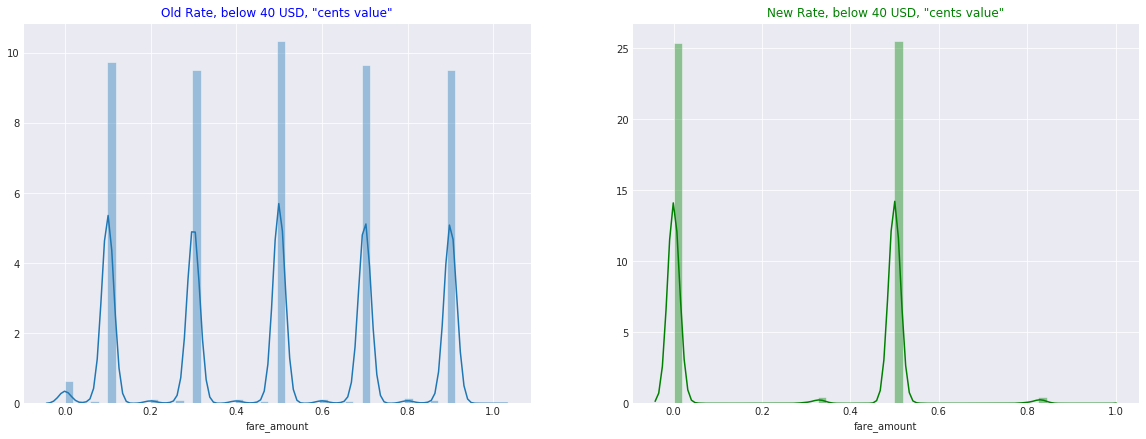

In [452]:
# Using mod function to extract the "cents value" of each ride
plt.figure(figsize = (20,7))
plt.subplot(1,2,1)
plt.title('Old Rate, below ' + str(a) + ' USD, "cents value"',color = "b")
sns.distplot(np.mod(df_before[df_before['fare_amount']<=a]['fare_amount'],1)) 
plt.subplot(1,2,2)
plt.title('New Rate, below ' + str(a) + ' USD, "cents value"',color = "g")
sns.distplot(np.mod(df_after[df_after['fare_amount']<=a]['fare_amount'],1), color='green'); 

We see clearly that before the fare rule change the "cents value" of the fare is almost always 0.1, 0.3, 0.5, 0.7 or 0.9, evenly distributed.
On the other side after the fare rule change the "cents value" of the fare is 0 or 0.5 with almost the same probability.
When trying to predict the fare of new taxi rides we will take this into consideration.

# Rides inside Manhattan  

Here we will analyse the rides that start and end inside Manhattan. Given the streets geometry of this area it makes sense that we can predict the taxi fares with higher precision than other type of rides. The first step is to define a polygon representing Manhattan. Then we can check if a given ride starts and ends inside the polygon.

In [453]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# Define polygon using coordinates (Just took them from Google Maps by clicking on the map)
lats_vect = [40.851638, 40.763022, 40.691262, 40.713380, 40.743944, 40.794344, 40.846332]
lons_vect = [-73.952423, -74.010418, -74.026685, -73.972200, -73.962051, -73.924073, -73.926454]
lons_lats_vect = np.column_stack((lons_vect, lats_vect))
polygon = Polygon(lons_lats_vect)

# Plot the polygon using Folium
man_map = folium.Map(location=[40.7631, -73.9712], zoom_start=12)
for i in range(0,6):
    folium.PolyLine(locations=[[lats_vect[i],lons_vect[i]], [lats_vect[i+1],lons_vect[i+1]]], color='blue').add_to(man_map)
folium.PolyLine(locations=[[lats_vect[6],lons_vect[6]], [lats_vect[0],lons_vect[0]]], color='blue').add_to(man_map)
man_map

Now that we defined our poligon we can filter our training set and extract only the rides that begin and end inside Manhattan. This may take a little time to compute.

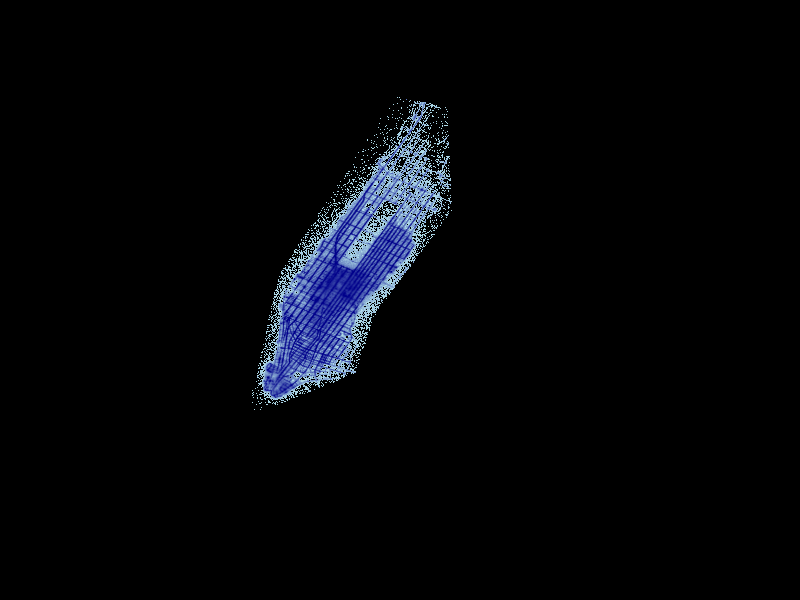

In [454]:
# Check for every point on df_train if it belongs to polygon or not
manhattanRides = df_train[df_train[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]
                          .apply(lambda row: ((polygon.contains(Point(row['pickup_longitude'],row['pickup_latitude']))) &
                                              (polygon.contains(Point(row['dropoff_longitude'],row['dropoff_latitude'])))), axis=1)]

# Plot the remaining dataset 'manhattanRides'
plot_data_points('pickup_longitude', 'pickup_latitude', manhattanRides)

Our hypothesis is that the distance of the trip is the strongest indicator to predict the price of the ride. Since we are in a very small area, there is not much difference between the Haversine distance and the Euclidean distance. In any case we will use the Manhattan distance since the area streets are like a grid. We should consider that Manhattan is about 29 degrees tilted compared to the north, and we should take that into consideration when calculating the Manhattan distance of the trip. For doing that we need to define some functions that will help us calculate the distance for every ride.

In [455]:
# Simple Euclidean Distance calculator 
def quickDist(lat1, lng1, lat2, lng2):
    lng1, lat1, lng2, lat2 = map(radians, [lng1, lat1, lng2, lat2])
    R = 6371
    x = (lng2 - lng1) * np.cos(0.5*(lat2+lat1))
    y = lat2 - lat1
    d = R * np.sqrt(x*x + y*y)
    return d

# Longitude distance (use same Euclidean distance function with fixed latitude)
def latDist(lat1, lng1, lat2, lng2):
    uno = quickDist((lat1+lat2)/2, lng1, (lat1+lat2)/2, lng2)
    return uno

# Calculate real distance (Manhattan distance with 29 degrees to north)
def realManDist(lat1, lng1, lat2, lng2):
    flightDist = quickDist(lat1, lng1, lat2, lng2)
    latDistance = latDist(lat1, lng1, lat2, lng2)
    if flightDist == 0:
        ret = np.nan
    else:
        th = np.arccos(latDistance/flightDist)
        ata = flightDist*np.cos(th-0.506) + flightDist*np.sin(th-0.506)
        bta = flightDist*np.cos(th+0.506) + flightDist*np.sin(th+0.506)
        ret = max(ata,bta)
    return ret

In [456]:
# Calculate distance for every ride on manhattanRides
manhattanRides['distance'] = manhattanRides.apply(lambda row: realManDist(row['pickup_latitude'], 
                                                                          row['pickup_longitude'], 
                                                                          row['dropoff_latitude'], 
                                                                          row['dropoff_longitude']), axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Let's check the percentage of the rides that are Manhattan rides. We get that 85% of the trips are Manhattan Rides. Having a good estimator for this kind of trips is extremely important.

In [457]:
print('Percentage of trips that happen inside Manhattan: ' + str(np.around(100*(manhattanRides.shape[0])/df_train.shape[0],2)))

Percentage of trips that happen inside Manhattan: 85.2


Now we will focus on building a model to predict the fare. Before we move on, let's split the manhattanRides dataframe into train and test, just so we can train a model using the train section and test the predictions accuracy using the test section. We will do 80% training and 20% testing using sklearn. Then we take a look at the train set by plotting the fare_amount against the distance.

In [458]:
# Split train/test
from sklearn.model_selection import train_test_split
manhattanRides_train, manhattanRides_test = train_test_split(manhattanRides, test_size=0.2, random_state=42)

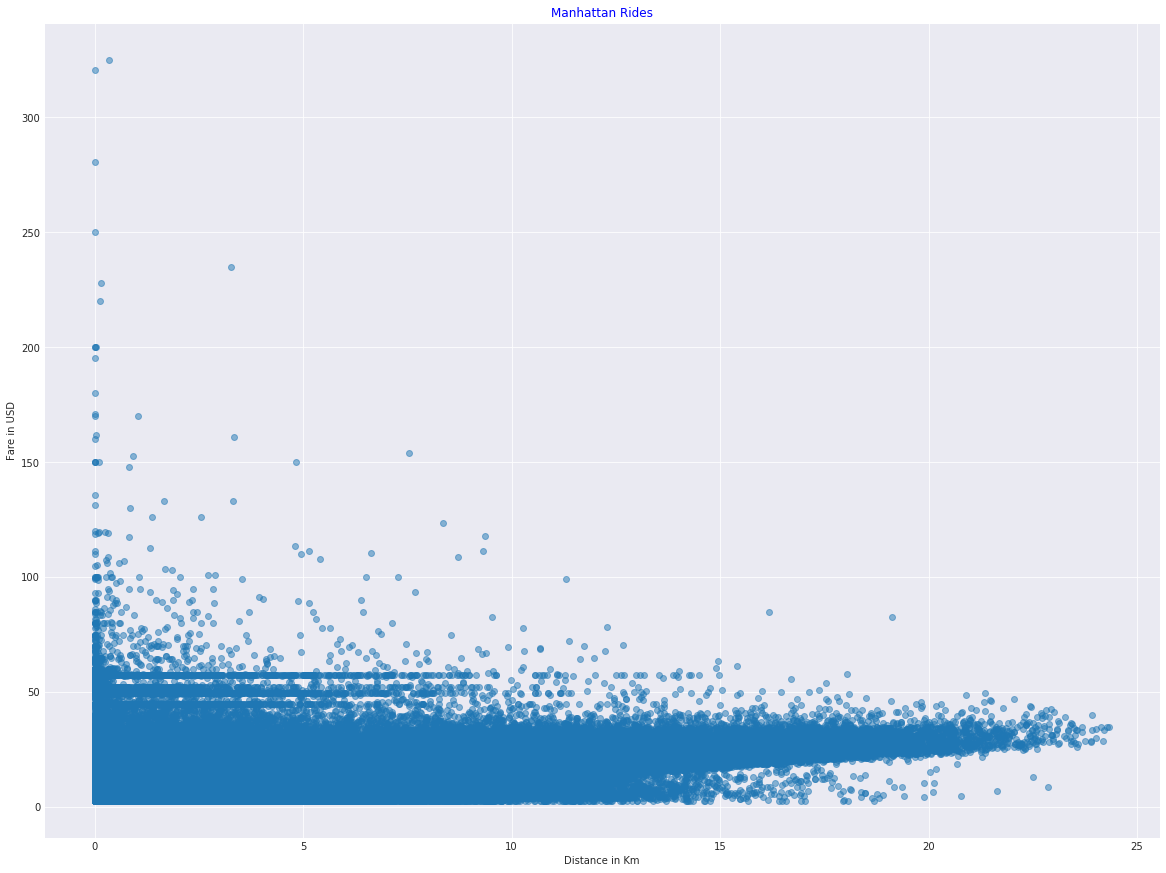

In [459]:
# Plot the 'fare_amount' against the distance of the trip
plt.figure(figsize = (20,15))
plt.title('Manhattan Rides', color = "b")
plt.ylabel('Fare in USD')
plt.xlabel('Distance in Km')
plt.scatter(manhattanRides_train['distance'], manhattanRides_train['fare_amount'], alpha=0.5);

There are some strange behaviors that we want to exclude from the dataset when building our model. We keep them to further analyse:  
1) High fare trips with distance close to 0.  
2) High distance trips with fare below 3 USD.  
3) Very high value outliers (above 75 USD).  
4) Fixed price trips around 50 USD no matter the distance.  

Let's filter and plot again:

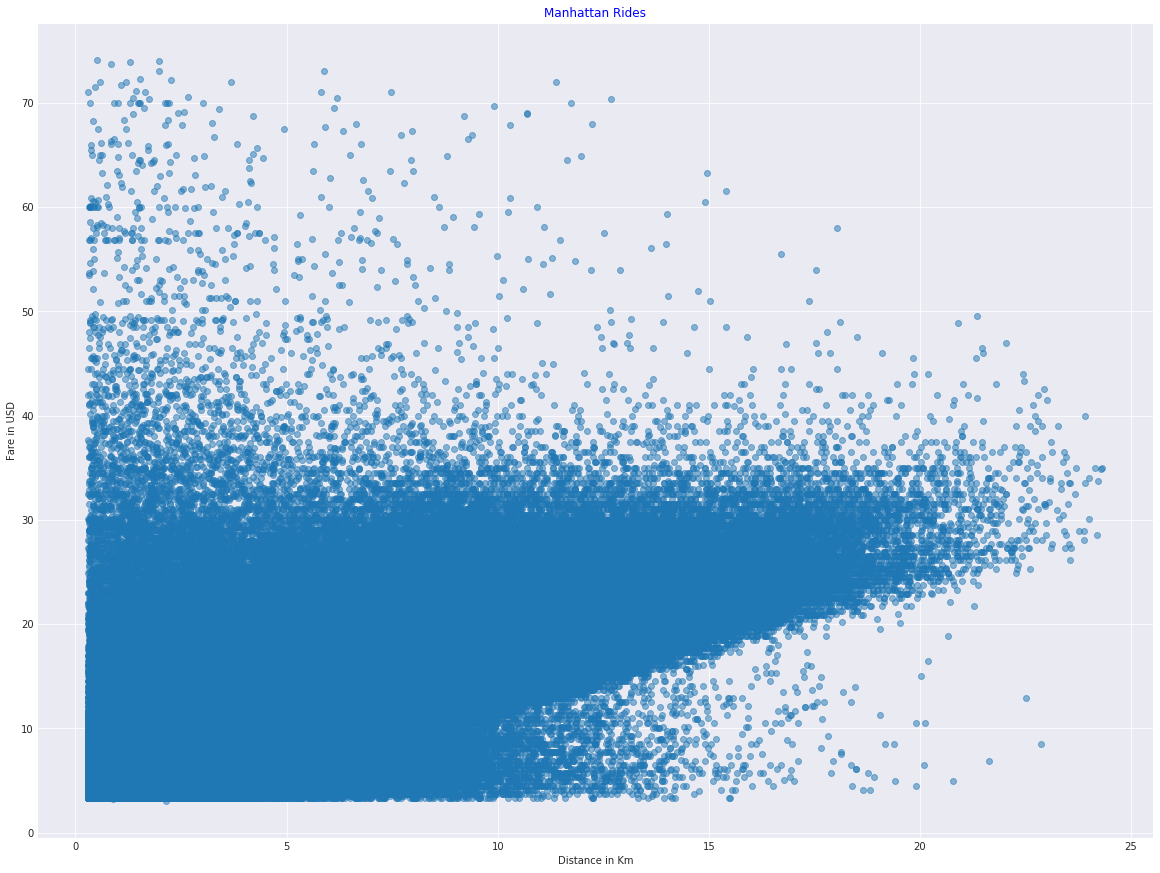

In [460]:
manhattanRides_shortDist = manhattanRides_train[manhattanRides_train['distance']<=0.3];
manhattanRides_highValue = manhattanRides_train[manhattanRides_train['fare_amount']>75];
manhattanRides_lowValue = manhattanRides_train[manhattanRides_train['fare_amount']<=3];

manhattanRides_train = manhattanRides_train[(manhattanRides_train['distance']>0.3)&(manhattanRides_train['fare_amount']<75)&(manhattanRides_train['fare_amount']>3)];

# Filter fare range
straight_lines = manhattanRides_train[(manhattanRides_train['fare_amount']>44)&(manhattanRides_train['fare_amount']<60)]
# Group by fare and count frequency
freq = straight_lines.groupby('fare_amount').count().sort_values('pickup_longitude', ascending=False)

# Keep the fare value of the top 8
fares_straight_lines = freq.index[0:7].values
# Extract from training dataframe
manhattanRides_straightLines = manhattanRides_train[manhattanRides_train['fare_amount'].isin(fares_straight_lines)]
manhattanRides_train = manhattanRides_train[~manhattanRides_train['fare_amount'].isin(fares_straight_lines)]
# Plot the 'fare_amount' against the distance of the trip
plt.figure(figsize = (20,15))
plt.title('Manhattan Rides', color = "b")
plt.ylabel('Fare in USD')
plt.xlabel('Distance in Km')
plt.scatter(manhattanRides_train['distance'], manhattanRides_train['fare_amount'], alpha=0.5);

Now we have a plot that makes more sense. Let's just write down the different datasets that we have now:  

__1) manhattanRides_shortDist:__  Trips with distance below 0.3 km  
__2) manhattanRides_highValue:__   Trips with fare_amounts above 75 USD  
__3) manhattanRides_lowValue:__  Trips with fare amounts below 3 USD  
__4) manhattanRides_straightLines:__  Trips with fixed amount despite distance (usually between 45 and 60 USD)  
__5) manhattanRides_train:__ Trips that don't belong to any of the above  

What would happen if we tried to fit a linear model to manhattanRides_train? What would the expected error be?   

A MSE of about 2.5 USD is not so good. We need to improve our model.

In [461]:
# Fitting a linear model and measuring the MSE
import statsmodels.api as sm

# Define function that makes regression and returns params
def measureMSE(df):
    regression = sm.OLS(df['fare_amount'], sm.add_constant(df['distance'])).fit()
    farepred = regression.predict(sm.add_constant(df['distance'])) 
    mse = np.around(np.sqrt((((df['fare_amount']-farepred)**2).sum())/(df.shape[0])),4)
    return [regression.params[1], regression.params[0], mse]

# Apply function on manhattanRides_train
reg = measureMSE(manhattanRides_train)

print ('Slope: ' + str(np.around(reg[0],2)))
print ('Intercept: ' + str(np.around(reg[1],2)))
print ('MSE: ' + str(np.around(reg[2],4)))

Slope: 1.44
Intercept: 4.02
MSE: 2.539


We know about the fare rules change. Let's split the data into before and after the fare rules change, plot the graphs and measure the MSE from a linear model in each case.  

The MSE for the BEFORE section improved while the MSE for the AFTER section worsen.

BEFORE - Slope: 1.29
BEFORE - Intercept: 3.84
BEFORE - MSE: 2.1568
AFTER - Slope: 1.66
AFTER - Intercept: 4.24
AFTER - MSE: 2.6353


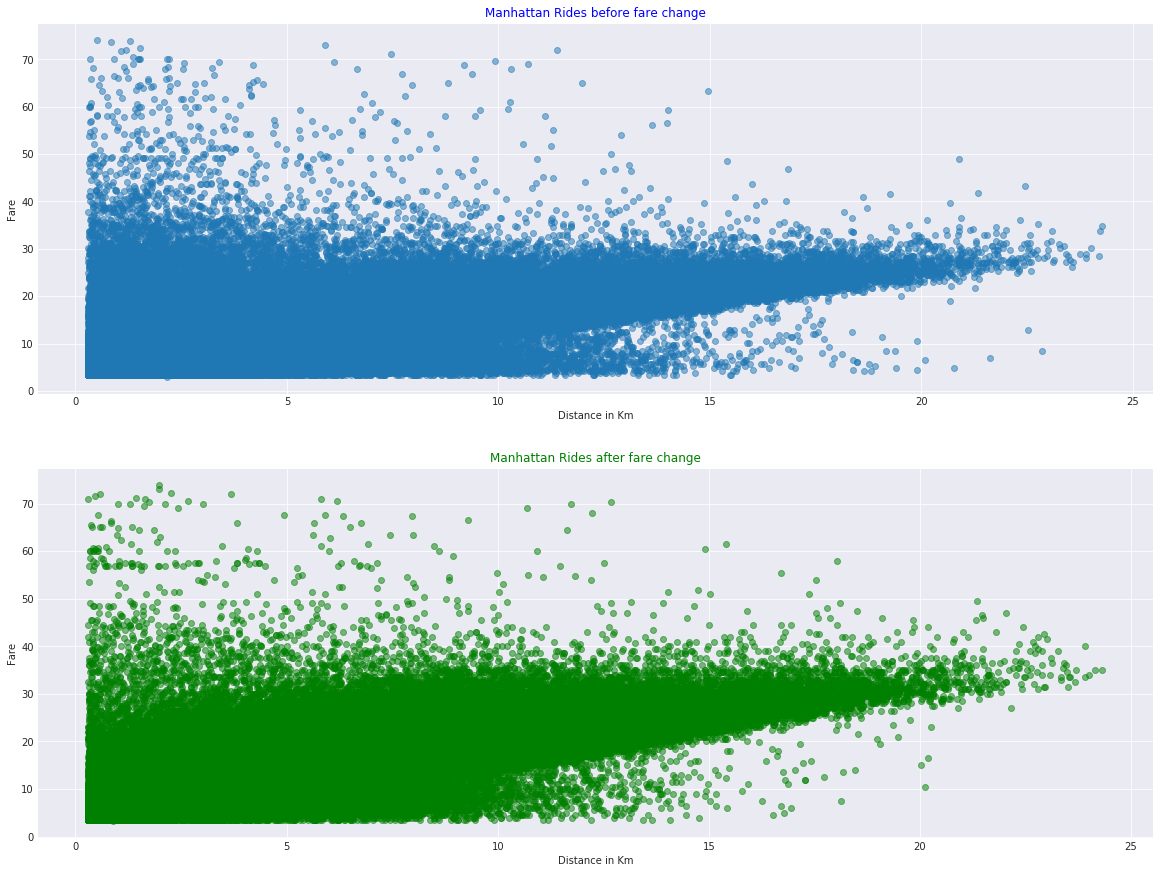

In [462]:
# Split the train set into before the fare rule change and after the fare rule change
manhattanRidesBefore = manhattanRides_train[manhattanRides_train['newRate']==False]
manhattanRidesAfter = manhattanRides_train[manhattanRides_train['newRate']==True]

# Fitting a linear model and measuring the MSE
reg = measureMSE(manhattanRidesBefore)
print ('BEFORE - Slope: ' + str(np.around(reg[0],2)))
print ('BEFORE - Intercept: ' + str(np.around(reg[1],2)))
print ('BEFORE - MSE: ' + str(np.around(reg[2],4)))

reg = measureMSE(manhattanRidesAfter)
print ('AFTER - Slope: ' + str(np.around(reg[0],2)))
print ('AFTER - Intercept: ' + str(np.around(reg[1],2)))
print ('AFTER - MSE: ' + str(np.around(reg[2],4)))

# Plot the 'fare_amount' against the distance of the trip
plt.figure(figsize = (20,15))
plt.subplot(2,1,1)
plt.title('Manhattan Rides before fare change', color = "b")
plt.ylabel('Fare')
plt.xlabel('Distance in Km')
plt.scatter(manhattanRidesBefore['distance'], manhattanRidesBefore['fare_amount'], alpha=0.5)
plt.subplot(2,1,2)
plt.title('Manhattan Rides after fare change', color = "g")
plt.ylabel('Fare')
plt.xlabel('Distance in Km')
plt.scatter(manhattanRidesAfter['distance'], manhattanRidesAfter['fare_amount'], color='green', alpha=0.5);

The data above mixes all trips inside Manhattan without any consideration of the day of the week or the hour of the day. Both the day of the week and the hour can have a great impact on traffic and this on the fare. Let's visualize how the plot looks for some specific day/hour combination. Let's also measure the MSE in this case.


BEFORE - Specifc daytime - Slope: 1.32
BEFORE - Specifc daytime - Intercept: 3.7
BEFORE - Specifc daytime - MSE: 1.9924
AFTER - Specifc daytime - Slope: 1.69
AFTER - Specifc daytime - Intercept: 3.95
AFTER - Specifc daytime - MSE: 2.1797


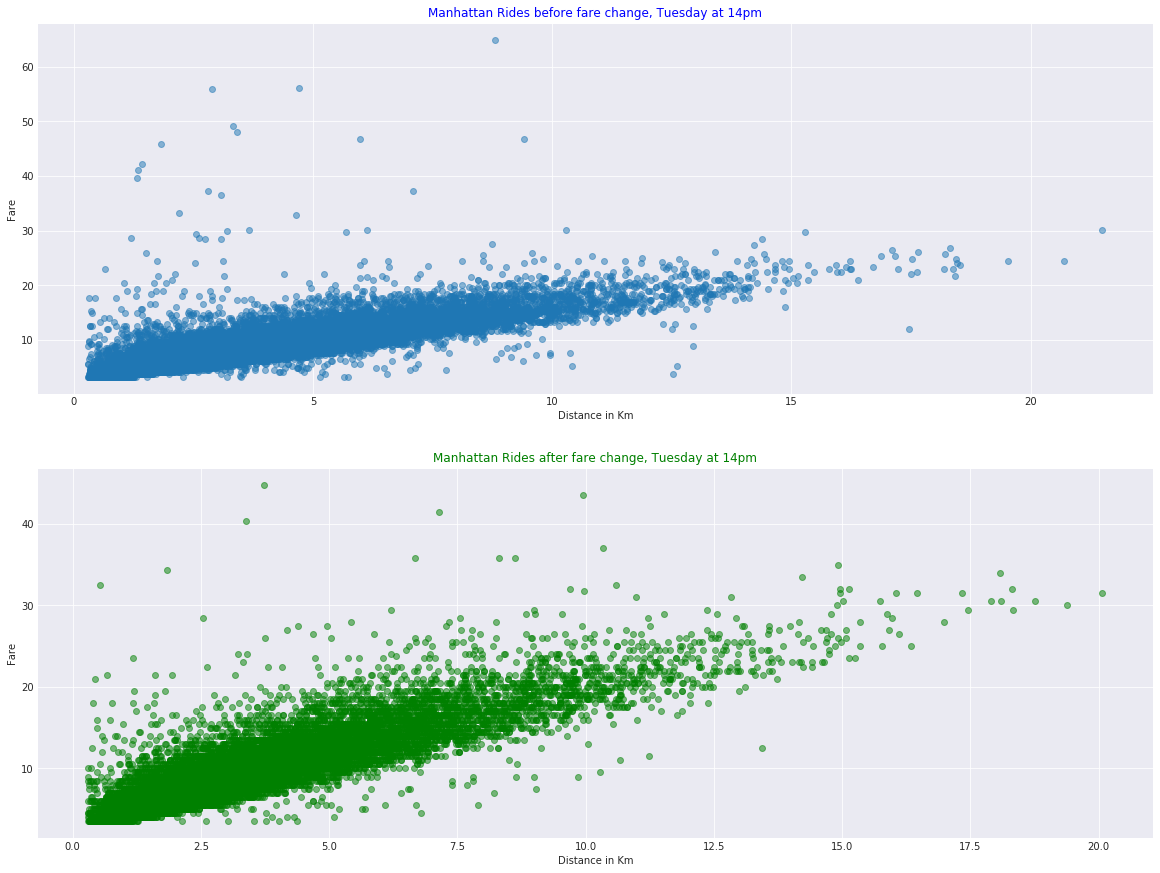

In [463]:
series1 = manhattanRidesBefore[(manhattanRidesBefore['weekday'] == 3) & (manhattanRidesBefore['hour'] == 20)]
series2 = manhattanRidesAfter[(manhattanRidesAfter['weekday'] == 3) & (manhattanRidesAfter['hour'] == 20)]

# Fitting a linear model and measuring the MSE
reg = measureMSE(series1)
print ('BEFORE - Specifc daytime - Slope: ' + str(np.around(reg[0],2)))
print ('BEFORE - Specifc daytime - Intercept: ' + str(np.around(reg[1],2)))
print ('BEFORE - Specifc daytime - MSE: ' + str(np.around(reg[2],4)))

reg = measureMSE(series2)
print ('AFTER - Specifc daytime - Slope: ' + str(np.around(reg[0],2)))
print ('AFTER - Specifc daytime - Intercept: ' + str(np.around(reg[1],2)))
print ('AFTER - Specifc daytime - MSE: ' + str(np.around(reg[2],4)))

plt.figure(figsize = (20,15))
plt.subplot(2,1,1)
plt.title('Manhattan Rides before fare change, Tuesday at 14pm', color = "b")
plt.ylabel('Fare')
plt.xlabel('Distance in Km')
plt.scatter(series1['distance'], series1['fare_amount'], alpha=0.5)
plt.subplot(2,1,2)
plt.title('Manhattan Rides after fare change, Tuesday at 14pm', color = "g")
plt.ylabel('Fare')
plt.xlabel('Distance in Km')
plt.scatter(series2['distance'], series2['fare_amount'], color='green', alpha=0.5);

This looks much better, and we could try to fit a linear model on this data and measure the MSE.

Following this idea we can iterate through the days of the week and the hours of the day and obtain the coefficients for that combination. At the end we get 4 tables:  

1) slopeMatrixBefore  
2) interMatrixBefore  
3) mseMatrixBefore

4) slopeMatrixAfter  
5) interMatrixAfter  
6) mseMatrixAfter


In [464]:
weekdaysOpt = [0,1,2,3,4,5,6]
hoursOpt = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

slopeMatBefore = np.zeros((7, 24))
interMatBefore = np.zeros((7, 24))
mseMatBefore = np.zeros((7, 24))

slopeMatAfter = np.zeros((7, 24))
interMatAfter = np.zeros((7, 24))
mseMatAfter = np.zeros((7, 24))

for i in weekdaysOpt:
    for j in hoursOpt:
        series1 = manhattanRidesBefore[(manhattanRidesBefore['weekday'] == i) & (manhattanRidesBefore['hour'] == j)]
        reg = measureMSE(series1)
        slopeMatBefore[i,j] = reg[0]
        interMatBefore[i,j] = reg[1]        
        mseMatBefore[i,j] = reg[2] 
        
        series2 = manhattanRidesAfter[(manhattanRidesAfter['weekday'] == i) & (manhattanRidesAfter['hour'] == j)]
        reg = measureMSE(series2)
        slopeMatAfter[i,j] = reg[0]
        interMatAfter[i,j] = reg[1]        
        mseMatAfter[i,j] = reg[2] 

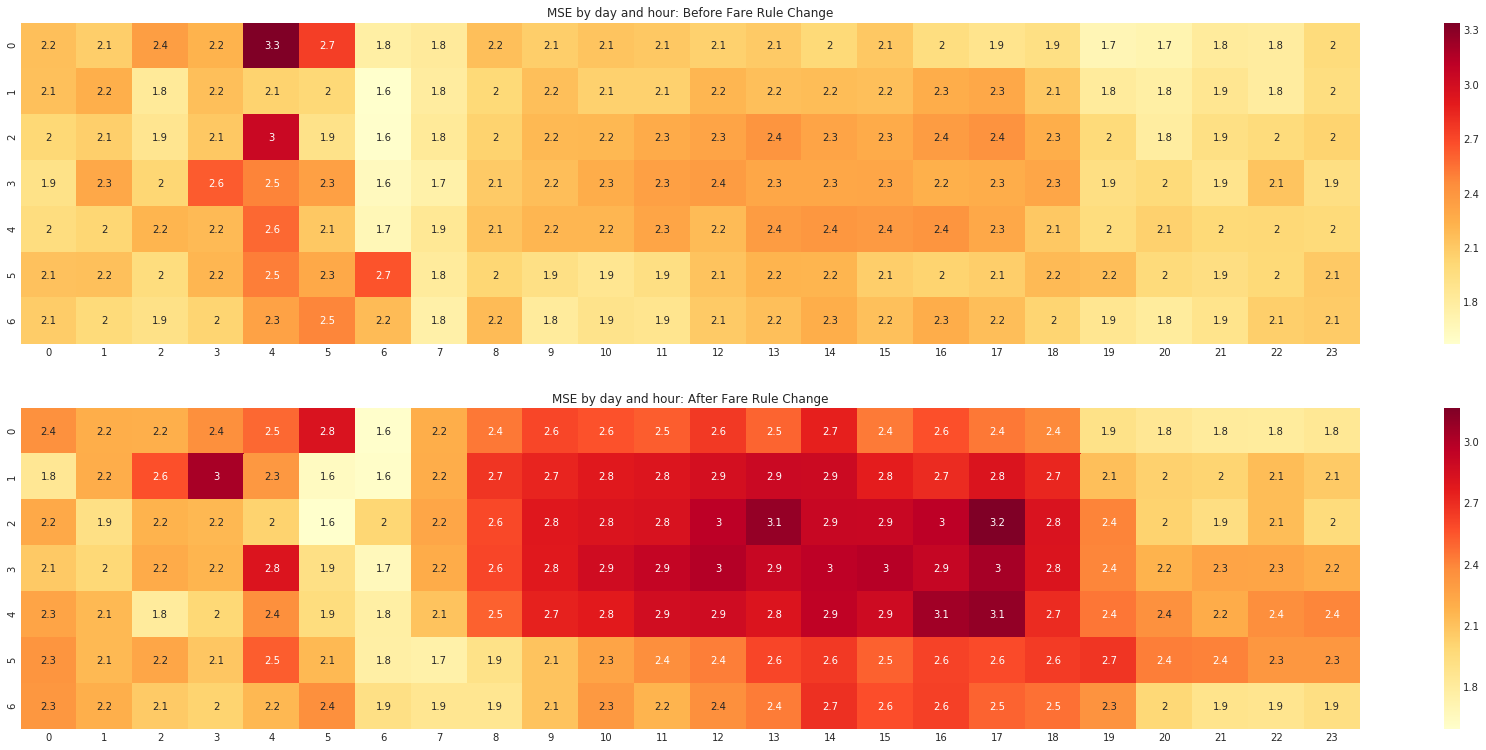

In [465]:
fig = plt.figure(figsize=(30,13))
ax1 = fig.add_subplot(211)
ax1.set_title('MSE by day and hour: Before Fare Rule Change')
sns.heatmap(mseMatBefore, xticklabels = hoursOpt, yticklabels = weekdaysOpt, annot = True, ax=ax1, cmap='YlOrRd')
ax2 = fig.add_subplot(212)
ax2.set_title('MSE by day and hour: After Fare Rule Change')
sns.heatmap(mseMatAfter, xticklabels = hoursOpt, yticklabels = weekdaysOpt, annot = True, ax=ax2, cmap='YlOrRd');


With the slope and intercept matrices we can build a prediction function

In [466]:
def predictManhattan(hour, day, new, distance, slopeMatBefore, interMatBefore, slopeMatAfter, interMatAfter):
    
    if new:
        slope = slopeMatAfter[day, hour]
        inter = interMatAfter[day, hour]
    else:
        slope = slopeMatBefore[day, hour]
        inter = interMatBefore[day, hour]  
        
    fare = inter + slope*distance
    
    return fare

Let's use this function to see the expected average MSE using the same training_set

In [467]:
predictions = manhattanRides_train.apply(lambda row: predictManhattan(row['hour'], row['weekday'], row['newRate'], row['distance'], slopeMatBefore, interMatBefore, slopeMatAfter, interMatAfter), axis=1)
print('The in-sample Average MSE is: ' + str(np.around(np.sqrt((((manhattanRides_train['fare_amount']-predictions)**2).sum())/manhattanRides_train.shape[0]),3)))

The in-sample Average MSE is: 2.258


Let's repeat using the test_set now

In [468]:
predictions = manhattanRides_test.apply(lambda row: predictManhattan(row['hour'], row['weekday'], row['newRate'], row['distance'], slopeMatBefore, interMatBefore, slopeMatAfter, interMatAfter), axis=1)
print('The out-of-sample average MSE is: ' + str(np.around(np.sqrt((((manhattanRides_test['fare_amount']-predictions)**2).sum())/manhattanRides_test.shape[0]),3)))

The out-of-sample average MSE is: 2.838


An out of sample MSE of 2.8 is not bad, but we can make it better if we understand more about the filtered cases (short distance trips, fixed value trips, etc).

Now we can have a look at the 4 cases that we filtered from the training set, they were:  

__1) manhattanRides_shortDist:__  Trips with distance below 0.3 km  
__2) manhattanRides_highValue:__   Trips with fare_amounts above 75 USD  
__3) manhattanRides_lowValue:__  Trips with fare amounts below 3 USD  
__4) manhattanRides_straightLines:__  Trips with fixed amount despite distance (usually between 45 and 60 USD)  

Visualize the pickup location and the dropoff location of the different groups:  

1) manhattanRides_shortDist:  __blue__  
2) manhattanRides_highValue:   __red__    
3) manhattanRides_lowValue:  __green__  
4) manhattanRides_straightLines: __yellow__   

In [469]:
def addMarkerPick(df, color, m1, m2):
    samples = df.sample(n=min(300,df.shape[0]))
    for lt, ln in zip(samples['pickup_latitude'], samples['pickup_longitude']):
            folium.Circle(location = [lt,ln] ,radius = 2, color = color).add_to(m1)
    for lt, ln in zip(samples['dropoff_latitude'], samples['dropoff_longitude']):
            folium.Circle(location = [lt,ln] ,radius = 2, color = color).add_to(m2)
        
m1 = folium.Map(location=[40.7631, -73.9712], zoom_start=13)
m2 = folium.Map(location=[40.7631, -73.9712], zoom_start=13)

addMarkerPick(manhattanRides_shortDist, 'blue', m1, m2)
addMarkerPick(manhattanRides_highValue, 'red', m1, m2)
addMarkerPick(manhattanRides_lowValue, 'green', m1, m2)
addMarkerPick(manhattanRides_straightLines, 'yellow', m1, m2)

In [470]:
m1

In [471]:
m2

There is not much grographical information or pattern to help us understand why these rides behave so strange.

# JFK - Manhattan airport rides  

The next group of rides are rides between JFK and Manhattan. This rides have very specific rules as we've seen at the beggining of the notebook. Let's first get all the rides of this kind.

In [472]:
# One end has to be JFK
jfk_lat_min = 40.626777
jfk_lat_max = 40.665599
jfk_lon_min = -73.823964
jfk_lon_max = -73.743085

# Filter trips originating on JFK
df_fromJFK = df_train[(df_train['pickup_latitude']<jfk_lat_max)&
                      (df_train['pickup_latitude']>jfk_lat_min)&
                      (df_train['pickup_longitude']<jfk_lon_max)&
                      (df_train['pickup_longitude']>jfk_lon_min)]

# Filter trips ending on JFK
df_toJFK = df_train[(df_train['dropoff_latitude']<jfk_lat_max)&
                    (df_train['dropoff_latitude']>jfk_lat_min)&
                    (df_train['dropoff_longitude']<jfk_lon_max)&
                    (df_train['dropoff_longitude']>jfk_lon_min)]

In [473]:
# The other end has to be Manhattan
df_fromJFK = df_fromJFK[df_fromJFK[['dropoff_latitude', 'dropoff_longitude']].apply(lambda row: polygon.contains(Point(row['dropoff_longitude'],row['dropoff_latitude'])), axis=1)]
df_toJFK = df_toJFK[df_toJFK[['pickup_latitude', 'pickup_longitude']].apply(lambda row: polygon.contains(Point(row['pickup_longitude'],row['pickup_latitude'])), axis=1)]

Let's check how many of the rides are this type of rides

In [474]:
print('Percentage of trips between JFK and Manhattan: ' + str(np.around(100*(df_fromJFK.shape[0] + df_toJFK.shape[0])/df_train.shape[0],2)))

Percentage of trips between JFK and Manhattan: 1.42


Quick look to the exact locations inside JFK for pickups and dropoffs:  

BLUE --> Pickup  
RED --> Dropoff  

In [475]:
m1 = folium.Map(location=[40.645580, -73.785115], zoom_start=16)
samples = df_fromJFK.sample(n=min(500,df_fromJFK.shape[0]))
for lt, ln in zip(samples['pickup_latitude'], samples['pickup_longitude']):
            folium.Circle(location = [lt,ln] ,radius = 2, color = 'blue').add_to(m1)
            
samples = df_toJFK.sample(n=min(500,df_toJFK.shape[0]))
for lt, ln in zip(samples['dropoff_latitude'], samples['dropoff_longitude']):
            folium.Circle(location = [lt,ln] ,radius = 2, color = 'red').add_to(m1)
        
m1

As before, we need to split between before the rate change and after the rate change. Let's have a visual look:

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



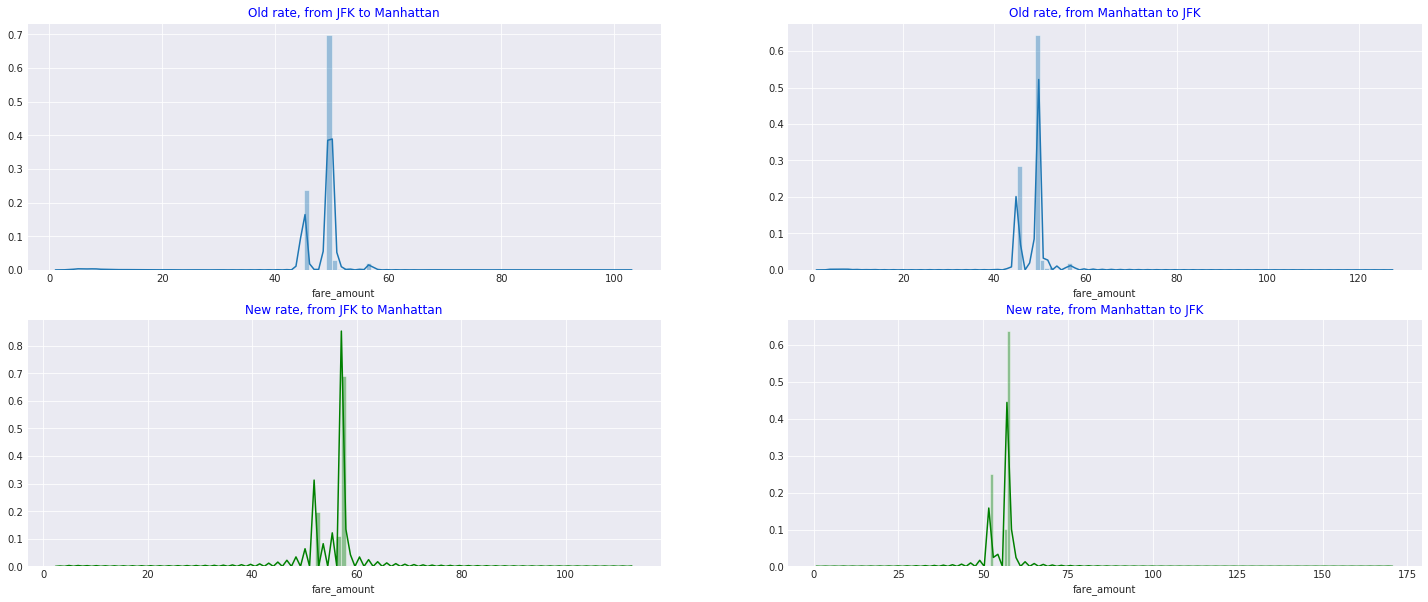

In [476]:
# Plot a histogram of the fares
plt.figure(figsize = (25,10))
plt.subplot(2,2,1)
plt.title('Old rate, from JFK to Manhattan',color = "b")
sns.distplot(df_fromJFK[df_fromJFK['newRate']==False]['fare_amount'], norm_hist=True, bins=np.arange(a,b))
plt.subplot(2,2,2)
plt.title('Old rate, from Manhattan to JFK',color = "b")
sns.distplot(df_toJFK[df_toJFK['newRate']==False]['fare_amount'], norm_hist=True, bins=np.arange(a,b))
plt.subplot(2,2,3)
plt.title('New rate, from JFK to Manhattan',color = "b")
sns.distplot(df_fromJFK[df_fromJFK['newRate']==True]['fare_amount'], norm_hist=True, bins=np.arange(a,b), color='green')
plt.subplot(2,2,4)
plt.title('New rate, from Manhattan to JFK',color = "b")
sns.distplot(df_toJFK[df_toJFK['newRate']==True]['fare_amount'], norm_hist=True, bins=np.arange(a,b), color='green');

In [477]:
# Add a weekend column
df_fromJFK['weekend'] = df_fromJFK['weekday'].isin([5,6])==True
df_toJFK['weekend'] = df_toJFK['weekday'].isin([5,6])==True

So far we have a good understanding of the fares between Manhattan and JFK for both before the fare rules change and after the fare rules change. Let's now have a look at how weekday/weekend and the hour of the day plays a role on the fare:

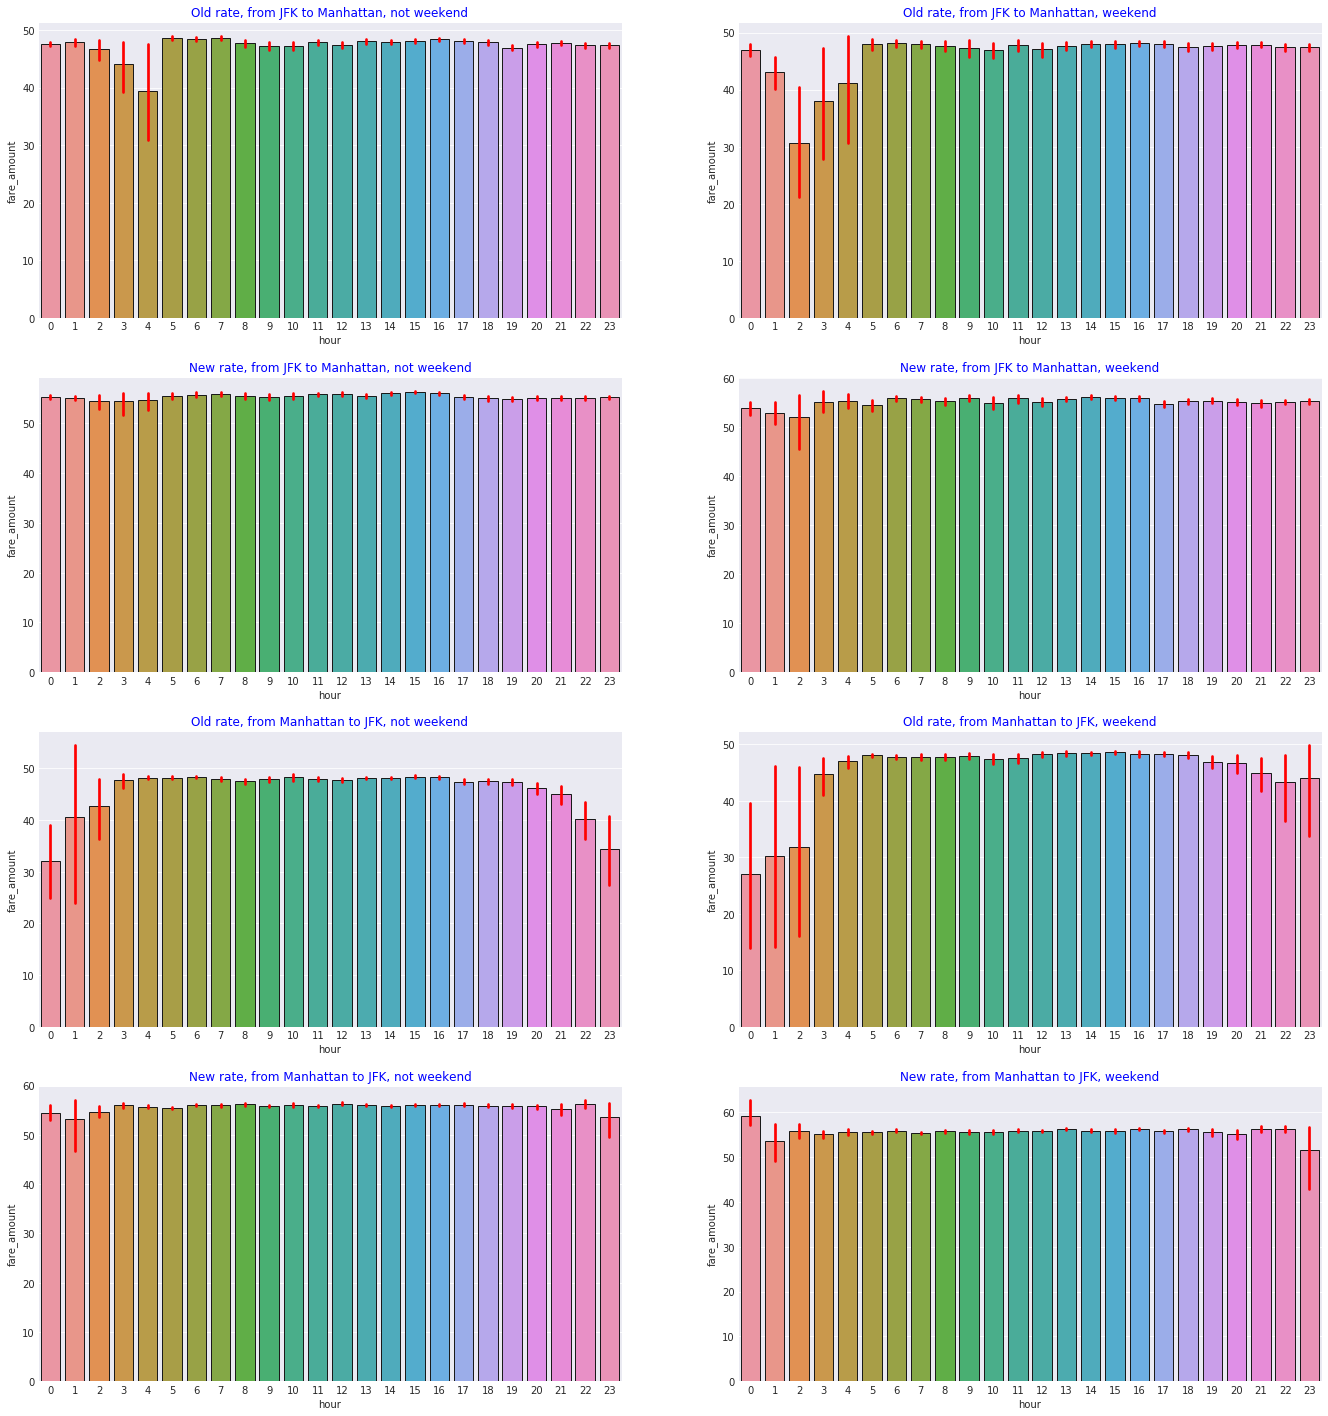

In [478]:
 def plotBars(df, newRate, weekend):
    frfr = df[(df['newRate']==newRate)&(df['weekend']==weekend)]
    sns.barplot(x='hour',y='fare_amount', data = frfr, edgecolor=".1", errcolor = 'red')
       
# Plot every combination
plt.figure(figsize = (23,25))
plt.subplot(4,2,1)
plt.title('Old rate, from JFK to Manhattan, not weekend',color = "b")
plotBars(df_fromJFK, False, False)
plt.subplot(4,2,2)
plt.title('Old rate, from JFK to Manhattan, weekend',color = "b")
plotBars(df_fromJFK, False, True)
plt.subplot(4,2,3)
plt.title('New rate, from JFK to Manhattan, not weekend',color = "b")
plotBars(df_fromJFK, True, False)
plt.subplot(4,2,4)
plt.title('New rate, from JFK to Manhattan, weekend',color = "b")
plotBars(df_fromJFK, True, True)
plt.subplot(4,2,5)
plt.title('Old rate, from Manhattan to JFK, not weekend',color = "b")
plotBars(df_toJFK, False, False)
plt.subplot(4,2,6)
plt.title('Old rate, from Manhattan to JFK, weekend',color = "b")
plotBars(df_toJFK, False, True)
plt.subplot(4,2,7)
plt.title('New rate, from Manhattan to JFK, not weekend',color = "b")
plotBars(df_toJFK, True, False)
plt.subplot(4,2,8)
plt.title('New rate, from Manhattan to JFK, weekend',color = "b")
plotBars(df_toJFK, True, True)

There is clearly an influence on weekday/weekend and on the time of the day. Specially during the night the fare average decreases and the standar deviation increases considerably. Thinking on doing predictions, we could just check the attributes of the taxi ride (day of week, hour of day, before/after fare rule change) and return the mean for that combination as we see in the figures above. That would give us a fair estimate but not perfect.  

Other option is to keep investigating the reason for the standard deviation on each column. My bet is that it is because of a toll (bridge, tunnel) depending on location inside Manhattan but I won't investigate that. Let's build the resulting matrix that will function as a check table when predicting.

In [479]:
# Define options
weekendOpt = [0, 1]
hoursOpt = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

# Initialize matrices
oldFromJFKtoMAN = np.zeros((2, 24))
newFromJFKtoMAN = np.zeros((2, 24))
oldFromMANtoJFK = np.zeros((2, 24))
newFromMANtoJFK = np.zeros((2, 24))

# Run combiantions
for i in weekendOpt:
    for j in hoursOpt:
        
        mean = df_fromJFK[(df_fromJFK['newRate']==False)&(df_fromJFK['weekend']==i)&(df_fromJFK['hour']==j)]['fare_amount'].mean()
        oldFromJFKtoMAN[i,j] = mean
        
        mean = df_fromJFK[(df_fromJFK['newRate']==True)&(df_fromJFK['weekend']==i)&(df_fromJFK['hour']==j)]['fare_amount'].mean()
        newFromJFKtoMAN[i,j] = mean
        
        mean = df_toJFK[(df_toJFK['newRate']==False)&(df_toJFK['weekend']==i)&(df_toJFK['hour']==j)]['fare_amount'].mean()
        oldFromMANtoJFK[i,j] = mean
        
        mean = df_toJFK[(df_toJFK['newRate']==True)&(df_toJFK['weekend']==i)&(df_toJFK['hour']==j)]['fare_amount'].mean()
        newFromMANtoJFK[i,j] = mean

In [480]:
# This are the prediction matrices
oldFromJFKtoMAN;
newFromJFKtoMAN;
oldFromMANtoJFK;
newFromMANtoJFK;

Let's evaluate our model using the same data:

In [481]:
# Prediction function
def predictAirport(isfrom, new, weekend, hour, oldFromJFKtoMAN, newFromJFKtoMAN, oldFromMANtoJFK, newFromMANtoJFK):
    if isfrom:
        if new:
            fare = newFromJFKtoMAN[weekend, hour]
        else:
            fare = oldFromJFKtoMAN[weekend, hour]
    else:
        if new:
            fare = newFromMANtoJFK[weekend, hour]
        else:
            fare = oldFromMANtoJFK[weekend, hour]            
    return fare

In [482]:
# From JFK
predictions = df_fromJFK.apply(lambda row: predictAirport(True, row['newRate'], row['weekend']*1, row['hour'], oldFromJFKtoMAN, newFromJFKtoMAN, oldFromMANtoJFK, newFromMANtoJFK), axis=1)
print('From JFK to Manhattan the MSE is: ' + str(np.around(np.sqrt((((df_fromJFK['fare_amount']-predictions)**2).sum())/df_fromJFK.shape[0]),3)))

# To JFK
predictions = df_toJFK.apply(lambda row: predictAirport(False, row['newRate'], row['weekend']*1, row['hour'], oldFromJFKtoMAN, newFromJFKtoMAN, oldFromMANtoJFK, newFromMANtoJFK), axis=1)
print('From Manhattan to JFK the MSE is: ' + str(np.around(np.sqrt((((df_toJFK['fare_amount']-predictions)**2).sum())/df_toJFK.shape[0]),3)))

From JFK to Manhattan the MSE is: 6.675
From Manhattan to JFK the MSE is: 5.026


It is not as good as for trips inside Manhattan but it's good enough for now